In [34]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python
# !pip install pandas
# !pip install scikit-learn 
# !pip uninstall helper -y

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ps33wvtm
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ps33wvtm
  Resolved https://github.com/albumentations-team/albumentations to commit dabc3b3688a1162c85abf771f60517b3417516de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [35]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


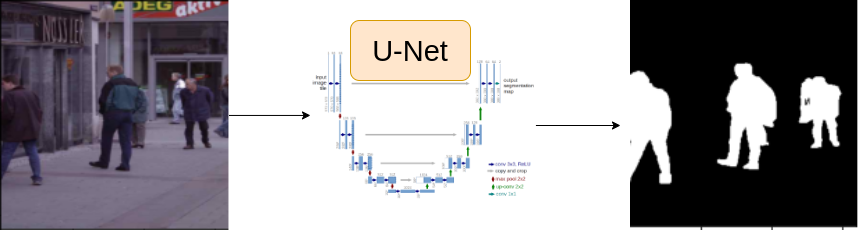

# Some Common Imports

In [36]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        


In [37]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [38]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Task : 2 Setup Configurations

In [39]:
CSV_FILE = '/kaggle/working/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/kaggle/working'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [40]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [41]:
row = df.iloc[3]

image_path = row.images
mask_path = row.masks

# Read the image (default is BGR in OpenCV)
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

print(image.shape, mask.shape)

(505, 786, 3) (401, 624)


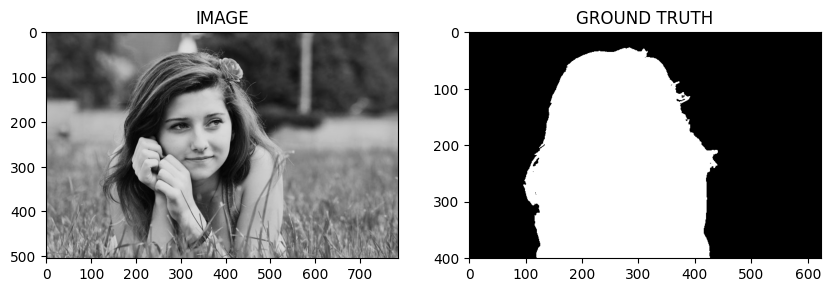

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [43]:
#split the data into train and validation
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [44]:
import albumentations as A

In [45]:
# Define augmentations
def get_train_augs():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ])

# Task 4 : Create Custom Dataset

In [46]:
from torch.utils.data import Dataset, DataLoader

In [47]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augs=None):
        self.df = df
        self.augs = augs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        image = cv2.imread(row.images)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row.masks, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        mask = np.expand_dims(mask, axis=-1)
        
        if self.augs:
            augmented = self.augs(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        
        image = torch.tensor(image) / 255.0
        mask = torch.round(torch.tensor(mask) / 255.0)
        
        return image, mask

In [48]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [49]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


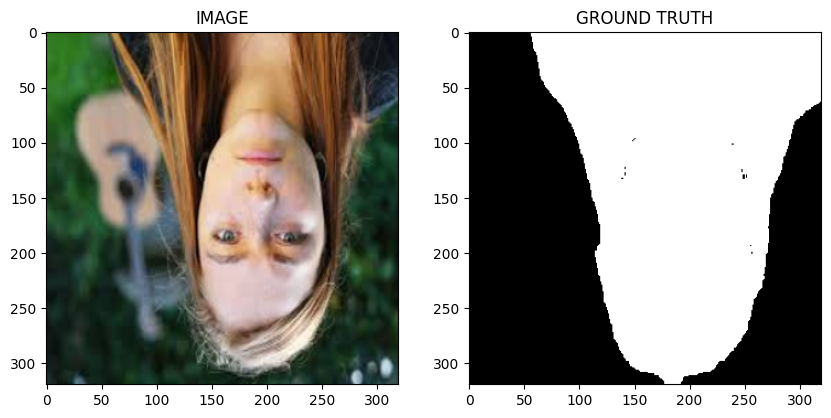

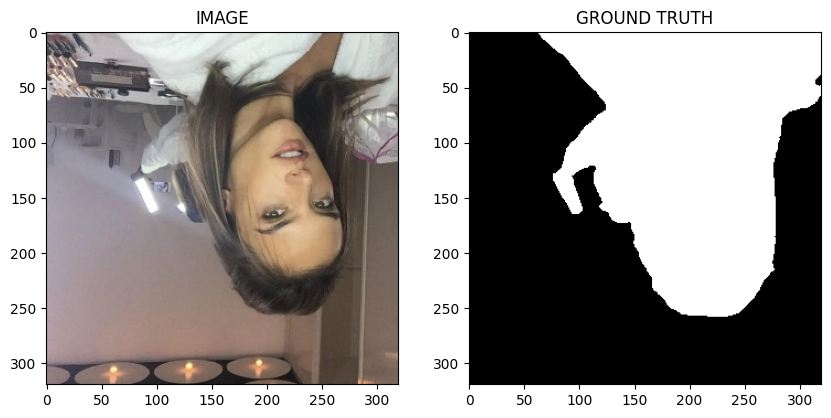

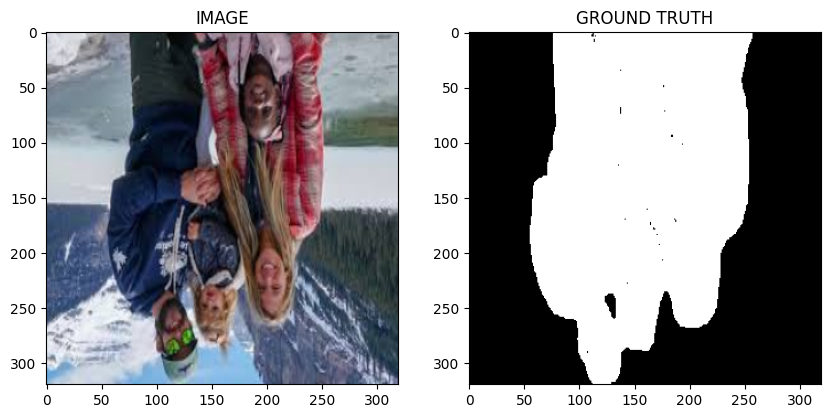

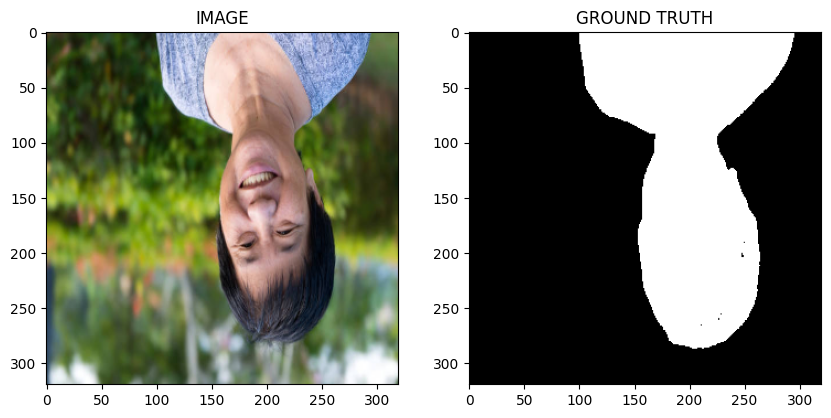

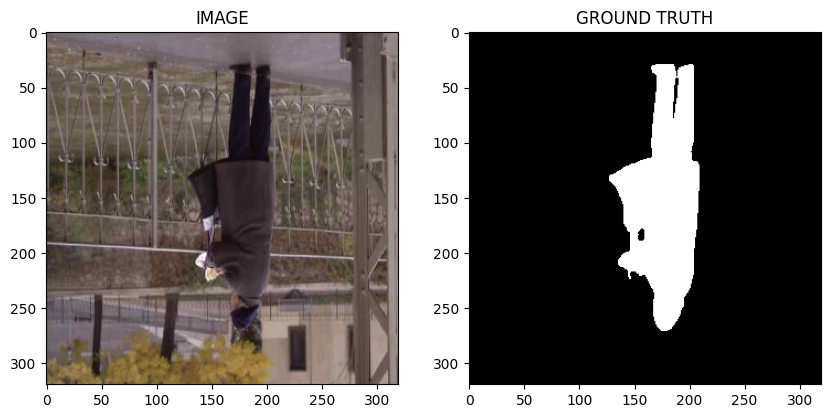

In [50]:
for idx in range(5):
    image, mask = trainset[idx]
    show_image(image, mask)


# Task 5 : Load dataset into batches

In [51]:
from torch.utils.data import DataLoader

In [52]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 15
Size of Validloader : 4


In [54]:
for image, mask in trainloader:
    break
print(image.shape, mask.shape)

torch.Size([16, 3, 320, 320]) torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [55]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [56]:
class SegmentationModel(nn.Module):
    def __init__(self, encoder, encoder_weights):
        super(SegmentationModel, self).__init__()
        
        self.model = smp.Unet(encoder, encoder_weights=encoder_weights, in_channels=3, classes=1, activation=None)
        
    def forward(self, x, masks=None):
        
        logits = self.model(x)
        
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [57]:
model = SegmentationModel(ENCODER, WEIGHTS)
model.to(DEVICE)

SegmentationModel(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigm

# Task 7 : Create Train and Validation Function

In [58]:
def train_fn(model, trainloader, optimizer):
    model.train()
    train_loss = 0
    for image, mask in tqdm(trainloader):
        image = image.to(DEVICE)
        mask = mask.to(DEVICE)
        
        optimizer.zero_grad() 
        
        logits, loss = model(image, mask)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    return train_loss / len(trainloader)

In [59]:
def eval_fn(model, validloader):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for image, mask in tqdm(validloader):
            image = image.to(DEVICE)
            mask = mask.to(DEVICE)

            logits, loss = model(image, mask)
            valid_loss += loss.item()
        
    return valid_loss / len(validloader)

# Task 8 : Train Model

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [61]:
best_valid_loss = np.inf
for epoch in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)
    
    print(f"EPOCH : {epoch} | TRAIN LOSS : {train_loss} | VALID LOSS : {valid_loss}")
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')

100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


EPOCH : 0 | TRAIN LOSS : 0.6638565838336945 | VALID LOSS : 2.7790300846099854


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


EPOCH : 1 | TRAIN LOSS : 0.3490535775820414 | VALID LOSS : 0.3057832829654217


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


EPOCH : 2 | TRAIN LOSS : 0.2703585465749105 | VALID LOSS : 0.25259697064757347


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


EPOCH : 3 | TRAIN LOSS : 0.22104858855406442 | VALID LOSS : 0.2316196858882904


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


EPOCH : 4 | TRAIN LOSS : 0.2652111560106277 | VALID LOSS : 0.293512687087059


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


EPOCH : 5 | TRAIN LOSS : 0.2415103167295456 | VALID LOSS : 0.23165054619312286


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


EPOCH : 6 | TRAIN LOSS : 0.18929974238077799 | VALID LOSS : 0.4526202045381069


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


EPOCH : 7 | TRAIN LOSS : 0.20850351601839065 | VALID LOSS : 0.27532313019037247


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


EPOCH : 8 | TRAIN LOSS : 0.18485911190509796 | VALID LOSS : 0.23830324783921242


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


EPOCH : 9 | TRAIN LOSS : 0.1572841539978981 | VALID LOSS : 0.1702796295285225


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


EPOCH : 10 | TRAIN LOSS : 0.15741933584213258 | VALID LOSS : 0.17079116962850094


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


EPOCH : 11 | TRAIN LOSS : 0.13799395908912024 | VALID LOSS : 0.1678392831236124


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


EPOCH : 12 | TRAIN LOSS : 0.1476265733440717 | VALID LOSS : 0.16073958948254585


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


EPOCH : 13 | TRAIN LOSS : 0.15683561166127521 | VALID LOSS : 0.21303711086511612


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


EPOCH : 14 | TRAIN LOSS : 0.16177914142608643 | VALID LOSS : 0.26188836246728897


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


EPOCH : 15 | TRAIN LOSS : 0.16392659147580466 | VALID LOSS : 0.17714352905750275


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


EPOCH : 16 | TRAIN LOSS : 0.17579390307267506 | VALID LOSS : 0.3379123732447624


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


EPOCH : 17 | TRAIN LOSS : 0.15095074226458868 | VALID LOSS : 0.1947663091123104


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


EPOCH : 18 | TRAIN LOSS : 0.11667166153589885 | VALID LOSS : 0.15721398033201694


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


EPOCH : 19 | TRAIN LOSS : 0.1102627585331599 | VALID LOSS : 0.15241797268390656


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


EPOCH : 20 | TRAIN LOSS : 0.10883798648913702 | VALID LOSS : 0.13711922615766525


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


EPOCH : 21 | TRAIN LOSS : 0.0874957948923111 | VALID LOSS : 0.1447753719985485


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


EPOCH : 22 | TRAIN LOSS : 0.1771134465932846 | VALID LOSS : 0.1943102404475212


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


EPOCH : 23 | TRAIN LOSS : 0.12232894698778789 | VALID LOSS : 0.17491896823048592


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

EPOCH : 24 | TRAIN LOSS : 0.11017755568027496 | VALID LOSS : 0.17261990904808044


# Task 9 : Inference

<ipython-input-67-e104dcbde5e8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


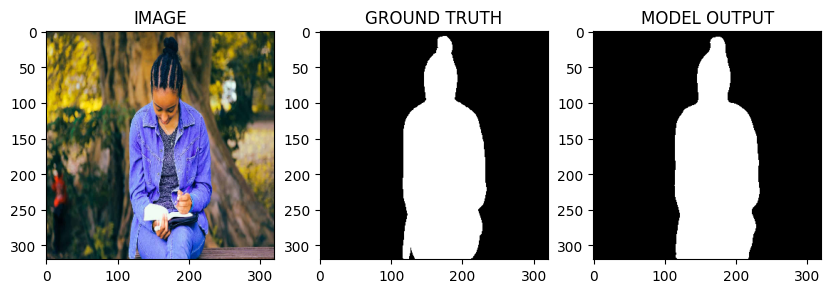

In [67]:
idx = 30

model.load_state_dict(torch.load('best_model.pth'))

image, mask = trainset[idx]

logits = model(image.unsqueeze(0).to(DEVICE))
pred_mask = torch.sigmoid(logits)
pred_mask = (pred_mask > 0.5)*1.0

show_image(image, mask, pred_mask.detach().cpu().squeeze(0))